**Aluno: Thiago Brito de Andrade Tenório**

**Email: tbat@cesar.school**

**DataSet: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data**

**Problema: Rice Image Classification With PyTorch**

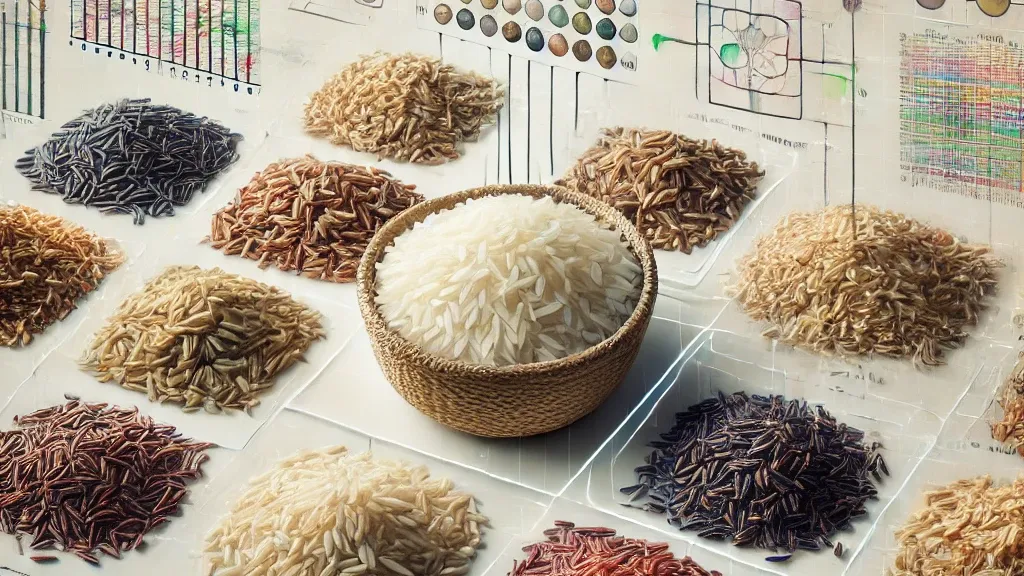

#Importando Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import kagglehub
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset
from glob import glob
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchsummary import summary
from sklearn.model_selection import train_test_split
import random
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader

#Baixando Base de Dados

In [ ]:
# Baixando o dataset do Kaggle
!curl -L -o rice-image-dataset.zip https://www.kaggle.com/api/v1/datasets/download/muratkokludataset/rice-image-dataset

# Descompactar o arquivo baixado
!unzip -q -o rice-image-dataset.zip -d rice_image_dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  219M  100  219M    0     0  96.4M      0  0:00:02  0:00:02 --:--:--  128M


In [ ]:
# Caminho onde os arquivos foram extraídos
dataset_path = "rice_image_dataset"

# Listar os diretórios e arquivos no dataset
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)

In [ ]:
# Listar as classes como subdiretórios
dataset_root = os.path.join(dataset_path, "Rice_Image_Dataset")

# Listar as classes como subdiretórios
rice_classes = os.listdir(dataset_root)
rice_classes.remove('Rice_Citation_Request.txt')

print("Classes encontradas:", rice_classes)

Classes encontradas: ['Karacadag', 'Arborio', 'Jasmine', 'Ipsala', 'Basmati']


#Separação das Imagens e suas Respectivas Classes

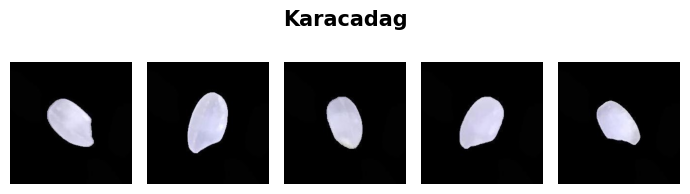

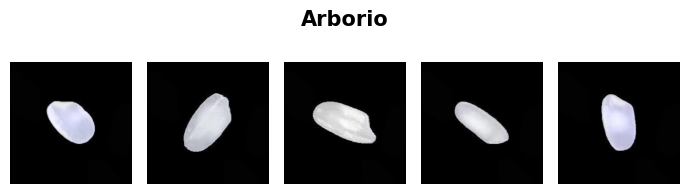

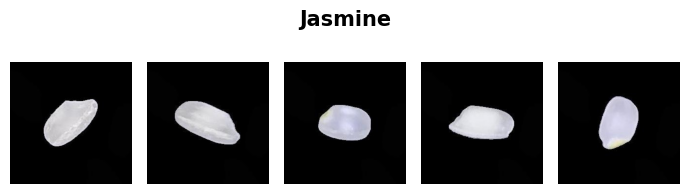

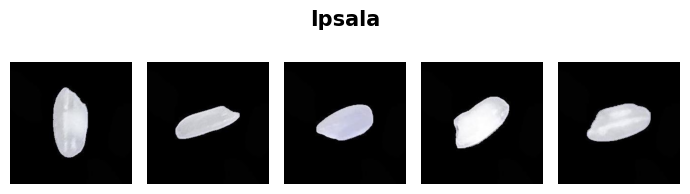

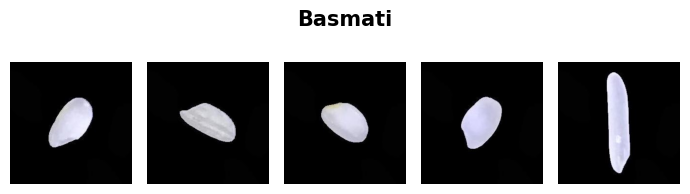

Total de imagens: 75000
Representação Numérica das CLasses: {0, 1, 2, 3, 4}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Obter as imagens e suas respectivas classes
images = []
labels = []

# Mapeamento de classes para números
class_mapping = {
    "Jasmine": 0,
    "Karacadag": 1,
    "Arborio": 2,
    "Ipsala": 3,
    "Basmati": 4
}

for class_name in rice_classes:
    class_path = os.path.join(dataset_root, class_name)
    class_images = glob(os.path.join(class_path, "*.jpg"))
    images.extend(class_images)
    labels.extend([class_mapping[class_name]] * len(class_images))

    random_images = random.choices(images, k=5)
    fig, ax = plt.subplots(1, 5, figsize=(7, 2))

    for i in range(5):
        plt.suptitle(class_name, fontsize=15, fontweight='bold')

        img = read_image(random_images[i])
        img = transforms.ToPILImage()(img)

        ax[i].imshow(img)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

print(f"Total de imagens: {len(images)}")
print(f"Representação Numérica das CLasses: {set(labels)}")

In [ ]:
#Classe Abstrata que Herda de Dataset
class RiceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Lê a imagem diretamente como tensor
        image = read_image(self.image_paths[idx])

        # Aplica transformações
        if self.transform:
            image = self.transform(image)

        # Converte o label para tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return image, label


##Construindo o Modelo

In [ ]:
class Modelo(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Modelo, self).__init__()
        # Camada de entrada para primeira camada oculta
        self.fc1 = nn.Linear(input_size, 512)
        # Segunda camada oculta
        self.fc2 = nn.Linear(512, 256)
        # Camada de saída
        self.fc3 = nn.Linear(256, num_classes)
        # Dropout para evitar overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Achatar a entrada
        x = x.view(x.size(0), -1)
        # Passa pela primeira camada com ReLU
        x = F.relu(self.fc1(x))
        # Passa pela segunda camada com ReLU
        x = F.relu(self.fc2(x))
        # Aplicar dropout
        x = self.dropout(x)
        # Camada de saída
        x = self.fc3(x)
        return x

##Treinamento

In [ ]:
# Divisão entre treinamento e teste
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Imagens de treinamento: {len(train_images)}")
print(f"Imagens de teste: {len(test_images)}")


Imagens de treinamento: 60000
Imagens de teste: 15000


In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Criação dos datasets
train_dataset = RiceDataset(train_images, train_labels, transform=transform)
test_dataset = RiceDataset(test_images, test_labels, transform=transform)

# Criação dos DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Laço Principal de Treinamento

In [ ]:
# Hiperparâmetros
input_size = 3 * 128 * 128  # Dimensão de entrada (imagens achatadas)
num_classes = 5             # 5 classes no dataset
learning_rate = 0.001
num_epochs = 10

# Inicializar a rede
model = Modelo(input_size, num_classes).to(device)

# Definir o caminho para salvar os pesos
best_model_path = "best_model.pth"
# Variável para guardar a menor perda
best_loss = float("inf")

# Definir a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Exemplo de treinamento
for epoch in range(num_epochs):
    model.train()  # Modo de treinamento
    running_loss = 0.0
    for images, labels in train_loader:
        # Enviar imagens e rótulos para o dispositivo (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass e atualização dos pesos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calcular a perda média da época
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Salvar o modelo se a perda for a menor registrada
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), best_model_path)

Epoch [1/10], Loss: 0.3354
Epoch [2/10], Loss: 0.1404
Epoch [3/10], Loss: 0.1181
Epoch [4/10], Loss: 0.1114
Epoch [5/10], Loss: 0.1061
Epoch [6/10], Loss: 0.0948
Epoch [7/10], Loss: 0.0935
Epoch [8/10], Loss: 0.0941
Epoch [9/10], Loss: 0.0915
Epoch [10/10], Loss: 0.0873


#Avaliação

In [ ]:
# Carregar os melhores pesos para testes
model.load_state_dict(torch.load(best_model_path))

# Avaliação no conjunto de teste
model.eval()  # Coloca o modelo em modo de avaliação
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

<ipython-input-12-d4f5363cdfc4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.0637
Test Accuracy: 98.29%


##Conclusões e Análises do Aprendizado

Após recepção de separaração de nossos dados entre Imagens e suas respectivas Classes, 20% desses dados serviram para testes e os outros 80% para treinamento.

A dimensão de nossas imagens era de 3 x 250 x 250, o que tornava nosso treinamento muito demorado devido ao numero de pesos existentes. Para isso foi feito uma redução das dimensões para 3 x 128 x 128. Além disso foi utilizada uma rede com camadas Fully Connected e utilizou-se a função de ativação Relu, muito útil em problemas mais complexos. Utilizou-se também a estratégia de Dropout, útil para evitar overfitting ao ignorar alguns neurônios durante o treinamento.

Nosso treinamento foi feito em 10 épocas, utilizando um learning rate = 0.001, a função de perda foi a CrossEntropyLoss, o otimizador escolhemos o Adam e fomos guardando os pesos da rede a cada melhor resultado de perda que encontrávamos, salvando isso no arquivo bes_model.pth que poderá ser utilizado posteriormente sem necessidade de retreinar a rede.

Com isso tivemos uma Acurácia de 98%.